In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#data processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

#ml models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor #download xgboost later?

from sklearn.metrics import mean_squared_error as mse

# Data Processing

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
#only 10 rows with missing data, dropping
data = data[data['MISSING_DATA'] == False]

In [6]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15 #subtracting 2 because one is for the opening bracket

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1

#creating response variable
data["LEN"] = data["POLYLINE"].apply(polyline_to_trip_duration)

In [7]:
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

data[["YR", "MON", "DAY", "HR", "WK"]] = (
    data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
)

In [10]:
##to save memory, we're sampling from the dataframe to cut the size in half
data = data.sample(frac = 0.5)

In [ ]:
data['ORIGIN_STAND'].fillna(-1, inplace = True)

In [11]:
train, valid = train_test_split(data, train_size = 0.7)

In [12]:
del data  #clearing memory since this dataframe is now redundant

In [18]:
X_train = train[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']] #add back in call_type once we fix that
y_train = train["LEN"]

In [26]:
X_valid = valid[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']] #add back in call_type once we fix that
y_valid = valid["LEN"]

In [29]:
X_valid['ORIGIN_STAND'].fillna(-1, inplace = True)

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_27802/3322181977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['ORIGIN_STAND'].fillna(-1, inplace = True)


**One Hot encoding**

In [24]:
#probably want to do an embedding instead
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder on the training data
encoder.fit(X_train[X_train.columns])
X_train_OH = encoder.transform(X_train[X_train.columns])


/Users/orenciolli/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Models

## Decision tree

In [25]:
depth = list(range(3,30))
param_grid =dict(max_depth =depth)
tree =GridSearchCV(DecisionTreeRegressor(),param_grid,cv =10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [55]:
y_train_pred =tree.predict(X_train) ##Predict train result
y_valid_pred =tree.predict(X_valid) ##Predict test result

In [56]:
np.sqrt(mse(y_valid.values, y_valid_pred))

685.1084014187679

## Random forest

In [51]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomForestRegressor(n_estimators = 600, max_depth = 30, 
                                         min_samples_split = 5, min_samples_leaf = 1)
random_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=600)

In [52]:
y_train_pred =random_regressor.predict(X_train) ##Predict train result
y_valid_pred =random_regressor.predict(X_valid) ##Predict test result

In [53]:
np.sqrt(mse(y_valid.values, y_valid_pred))

700.4351527695006

In [54]:
np.sqrt(mse(y_train.values, y_train_pred))

629.7193101054833

## 10 worst predictions

In [67]:
with_preds = train.copy()
with_preds['diff'] = abs(train['LEN'] - y_train_pred)

In [73]:
ten_worst = with_preds.sort_values(by = 'diff', ascending = False).iloc[:10][['POLYLINE', 'diff']]

In [76]:
ten_worst.reset_index()

,index,POLYLINE,diff
0,224510,"[[-8.618148,41.167557],[-8.618409,41.167575],[...",50848.695652
1,1003876,"[[-8.672364,41.154831],[-8.670393,41.155974],[...",39310.942123
2,849531,"[[-8.621415,41.156316],[-8.621064,41.155749],[...",39005.886076
3,369196,"[[-8.654823,41.173047],[-8.655777,41.172246],[...",38674.151292
4,12213,"[[-8.605917,41.144364],[-8.606232,41.144499],[...",37087.351308
5,571625,"[[-8.592858,41.179743],[-8.592948,41.181903],[...",36934.428956
6,280007,"[[-8.585649,41.148927],[-8.586126,41.148936],[...",36066.428015
7,321258,"[[-8.623413,41.184828],[-8.623602,41.184747],[...",35389.428956
8,633224,"[[-8.613216,41.155398],[-8.614404,41.155659],[...",35064.470626
9,1560379,"[[-7.49133,37.184832],[-7.491906,37.187829],[-...",32906.836393


In [81]:
eval(ten_worst.reset_index()['POLYLINE'].iloc[0])

[[-8.618148, 41.167557],
 [-8.618409, 41.167575],
 [-8.619768, 41.167782],
 [-8.621703, 41.167656],
 [-8.623323, 41.167557],
 [-8.624637, 41.167179],
 [-8.62479, 41.167098],
 [-8.624808, 41.167107],
 [-8.624763, 41.167161],
 [-8.625429, 41.166963],
 [-8.626599, 41.166504],
 [-8.628237, 41.166009],
 [-8.630154, 41.165244],
 [-8.632206, 41.164371],
 [-8.634285, 41.163687],
 [-8.636625, 41.164416],
 [-8.638839, 41.164974],
 [-8.640414, 41.165928],
 [-8.642106, 41.16735],
 [-8.641917, 41.168205],
 [-8.642988, 41.166783],
 [-8.646129, 41.165181],
 [-8.649153, 41.162985],
 [-8.648748, 41.159826],
 [-8.64621, 41.156865],
 [-8.644761, 41.153634],
 [-8.641971, 41.151168],
 [-8.640648, 41.14836],
 [-8.639982, 41.145633],
 [-8.639271, 41.142654],
 [-8.637669, 41.139657],
 [-8.635743, 41.136813],
 [-8.6355, 41.13369],
 [-8.635734, 41.13036],
 [-8.635905, 41.127057],
 [-8.636049, 41.123817],
 [-8.635788, 41.120829],
 [-8.633322, 41.118372],
 [-8.62956, 41.116131],
 [-8.624889, 41.114754],
 [-8.6203

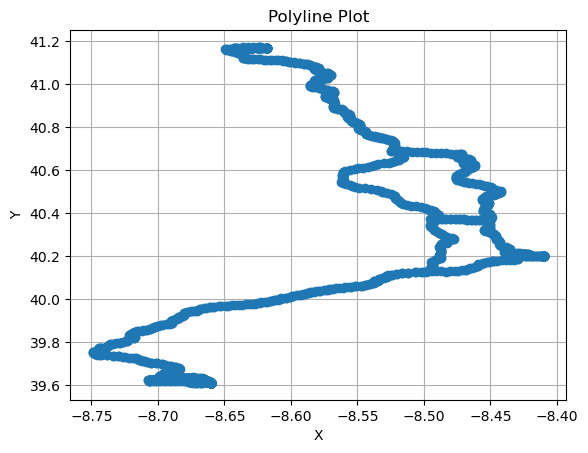

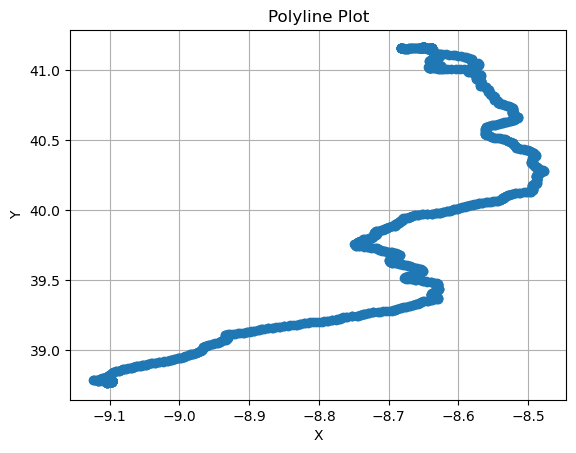

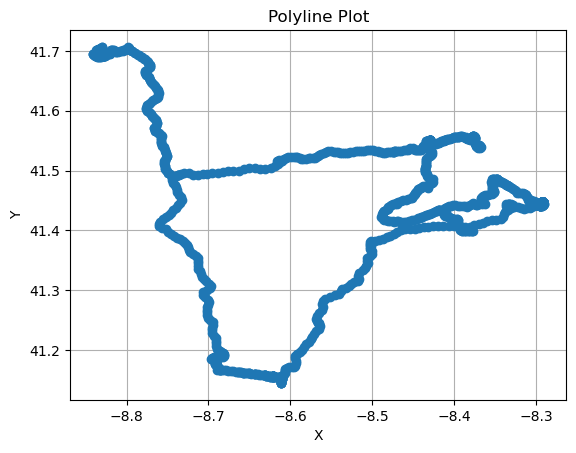

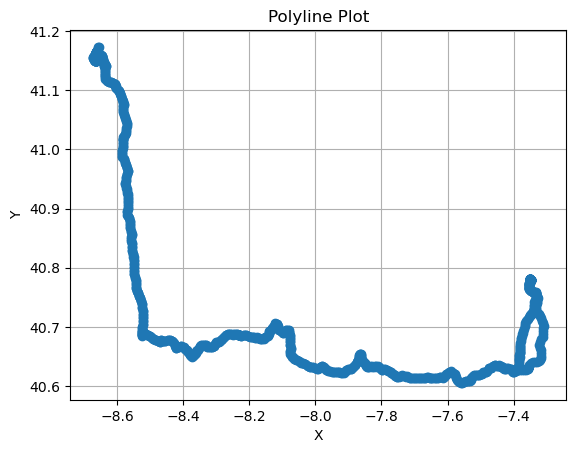

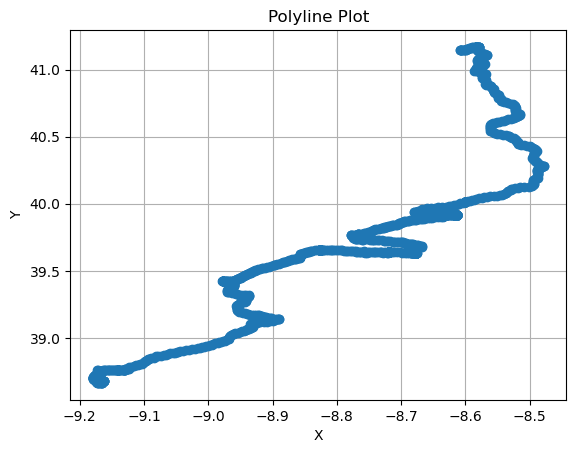

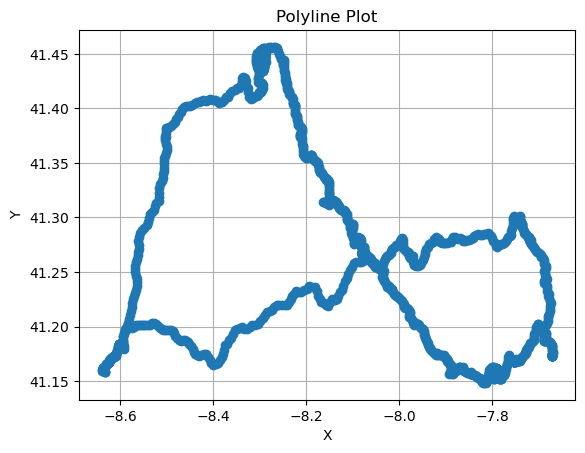

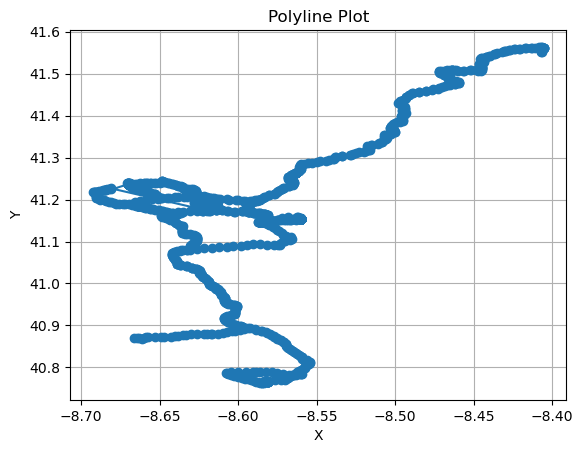

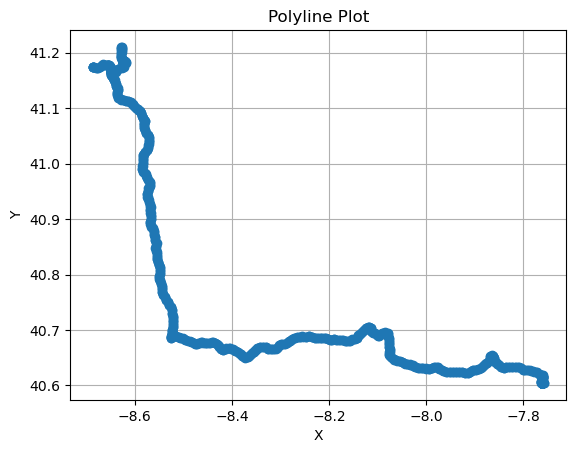

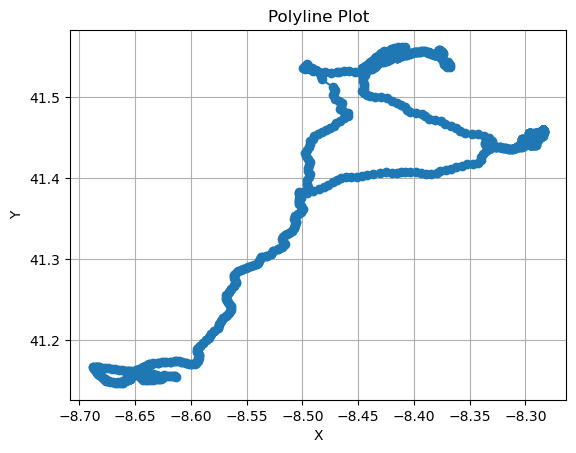

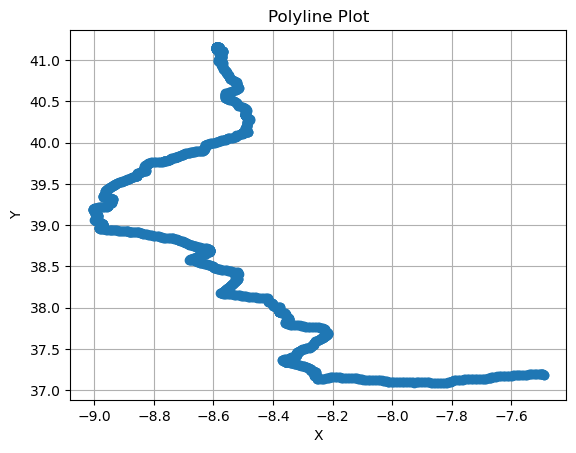

In [90]:
def plot_polyline(polyline):
    x = [point[0] for point in polyline]
    y = [point[1] for point in polyline]

    plt.plot(x, y, '-o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polyline Plot')
    plt.grid(True)
    plt.show()


for i in range(10):
    plot_polyline(
        eval(
            ten_worst.reset_index()['POLYLINE'].iloc[i]
        )
        )
    


## Prediction file

In [35]:
test_data = pd.read_csv('data/test_public.csv')

In [36]:
test_data[["YR", "MON", "DAY", "HR", "WK"]] = (
    test_data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
)

In [37]:
X_test = test_data[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']]
X_test['ORIGIN_STAND'].fillna(-1, inplace = True)

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_27802/2438542890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ORIGIN_STAND'].fillna(-1, inplace = True)


In [38]:
X_test_OH = encoder.transform(X_test[X_test.columns])

In [39]:
#predicting with decision tree
preds = tree.predict(X_test)

In [42]:
final_preds = pd.DataFrame({'TRIP_ID': test_data['TRIP_ID'], 'TRAVEL_TIME': preds})
final_preds.to_csv('tree_preds.csv', index = False)